In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [143]:
# Define parameters
N = 500
T = 300
M = 50000
dt = 0.01
t0 = 0

pi = np.pi

k = 1
a = 0.1
b = 0.26
c = -65
d = 0 #-1

A = 0.04
B = 5
C = 140

# v_reset = -10/A - B/(2*A)
# v_thresh = 10/A - B/(2*A) 

v_reset = -1000
v_thresh = 1000

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

p_jump = 2.7185823035951033

# Heterogeneity parameters for the intrinsic current eta
Delta = 0.02     # half-width of Lorentzian for eta
etaBar = 0.8     # mean intrinsic current

J = stats.cauchy.rvs(loc=etaBar, scale=Delta, size=N)
I = 0

# All-to-all connected, can use single s and p as all neuron receive same input
g = 0.2

In [144]:
# Network simulation functions
def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N]
    p = x[-1]
    
    dvdt = k * (A*v**2 + B*v + C - u + I) + J - (v - Esyn)*g*s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, [dsdt], [dpdt]])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

In [145]:
# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Fixed Point, Bifurcation Analysis  and Trajectory Plot for $\bar{\eta}$ 

In [146]:
# Physical FP r>0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.8]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.80, Fixed point (r, v, u, s, p): 0.03163042142907949, -61.94645664836426, -16.10607872857471, 0.2616709789941407, 0.2616709789941407
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.5750204959696923e-15, 6.675215935558754e-13]
du/dt, ds/dt, dp/dt: [0.0, -1.3877787807814457e-17, -1.3877787807814457e-17]


In [147]:
# Unphysical FP r<0
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [-0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.8]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.80, Fixed point (r, v, u, s, p): -0.09801935976853907, -64.49475313815964, -16.768635815921506, -0.8108909294339092, -0.8108909294339092
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.031637661922825e-13, -1.652589176615038e-11]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [148]:
r_fp, v_fp, u_fp, s_fp, p_fp =0.03163042142907949, -61.94645664836426, -16.10607872857471, 0.2616709789941407, 0.2616709789941407
etaBar = 0.8
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-8.05072767e-03  2.53043371e-03  0.00000000e+00 -6.32608429e-03
   0.00000000e+00]
 [-1.56089873e+01 -8.05072767e-03 -1.00000000e+00 -1.61070867e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (0.01313257919981108+0.2702842907664105j)
Corresponding eigenvector:
[ 0.00119359-0.01027151j  0.99277487+0.j          0.03401406-0.08126276j
 -0.0457408 -0.01660193j -0.03391388-0.05488659j]

Eigenvalue 2: (0.01313257919981108-0.2702842907664105j)
Corresponding eigenvector:
[ 0.00119359+0.01027151j  0.99277487-0.j          0.03401406+0.08126276j
 -0.0457408 +0.01660193j -0.03391388+0.05488659j]

Eigenvalue 3: (-0.3479028670311465+0.07736201988872078j)
Corresponding eigenvector:
[ 0.00179831+0.00079081j -0.95

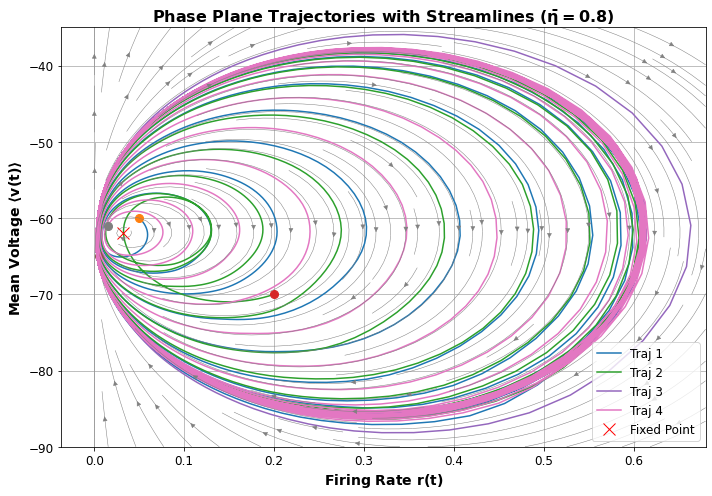

In [149]:
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.68, 25)
v = np.linspace(-90, -35, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\bar{\eta} = 0.8)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_EtaBar_0.8.png')
plt.show()

In [150]:
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:

initial_guess = [0.12 , -62]  # initial guesses for r, v
etaBar_values = [0.1]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]

etaBar = 0.10, Fixed point (r, v, u, s, p): 0.009464288321004342, -62.64058779770183, -16.286552827402478, 0.07829581392055737, 0.07829581392055737
Residuals (should be close to zero):
dr/dt, dv/dt: [1.3434393571556957e-12, -1.4922843516451678e-10]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


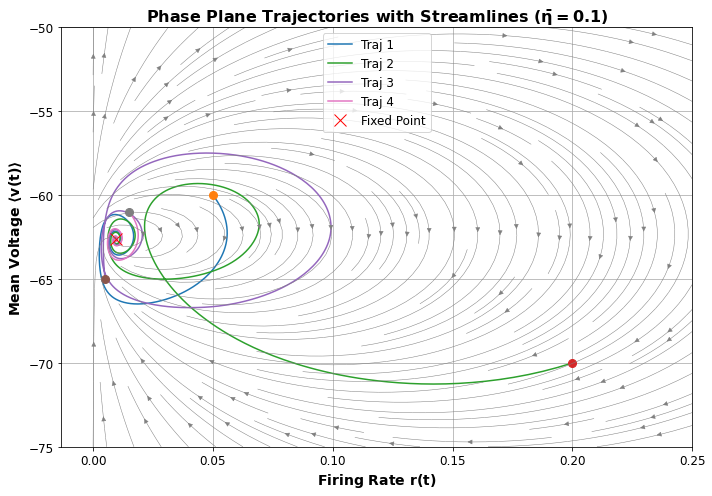

In [151]:
r_fp, v_fp, u_fp, s_fp, p_fp = 0.009464288321004342, -62.64058779770183, -16.286552827402478, 0.07829581392055737, 0.07829581392055737
etaBar = 0.1
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.25, 25)
v = np.linspace(-75, -50, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\bar{\eta} = 0.1)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_EtaBar_0.1.png')
plt.show()

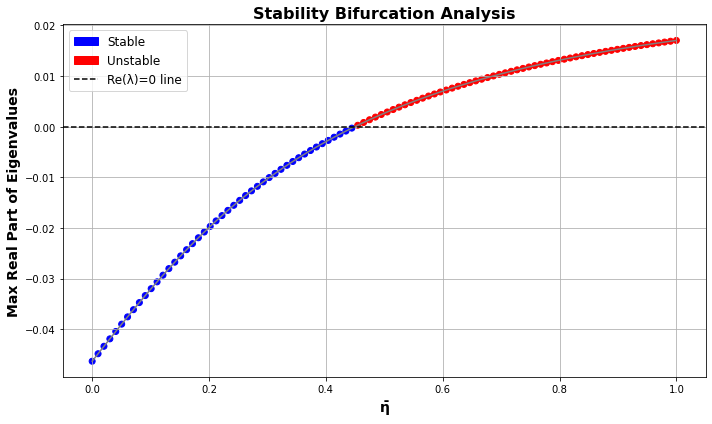

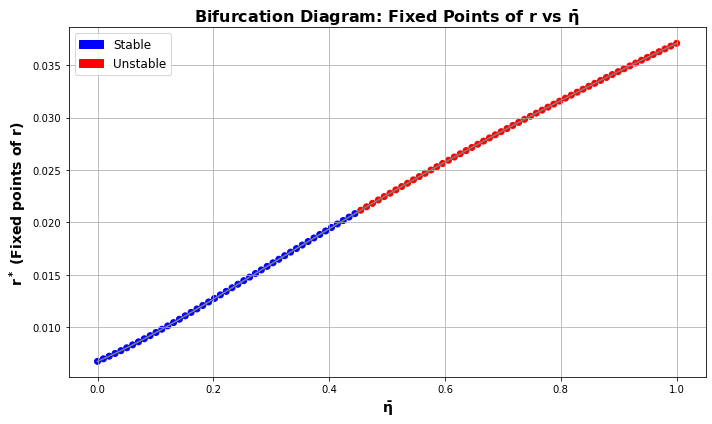

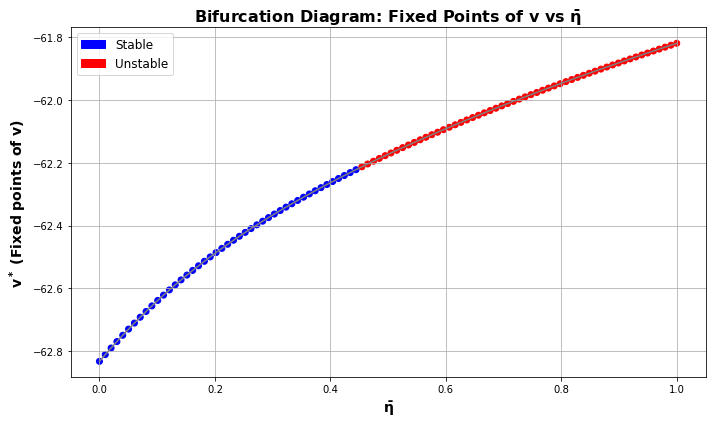

Bifurcation point 1: etaBar ≈ 0.449434


In [175]:

# Parameters (make sure these are defined correctly for your system)
etaBar_values = np.linspace(0, 1, 100)
initial_guess = [0.120, -62]

# Storage arrays
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []

# Filtered arrays for bifurcation point detection
etaBar_success = []
max_real_eigvals_success = []

# Loop through etaBar values
for etaBar in etaBar_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta,), full_output=True)

    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Jacobian matrix at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        # Eigenvalue analysis
        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        # Save only successful results for bifurcation search
        etaBar_success.append(etaBar)
        max_real_eigvals_success.append(max_real_part)

#         print(f"etaBar = {etaBar:.3f}, Max real eigenvalue: {max_real_part:.6f}, "
#               f"Stability: {stabilities[-1]}, Fixed Point r*: {r_fp:.6f}")

        # Update initial guess
        initial_guess = [r_fp, v_fp]

#     else:
#         print(f"fsolve failed for etaBar = {etaBar:.3f}")

# Convert to arrays
etaBar_values = np.array(etaBar_values)
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
stabilities = np.array(stabilities)

# Define colors for plotting
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# === Plot max eigenvalue vs etaBar ===
plt.figure(figsize=(10, 6))
plt.plot(etaBar_values[:len(max_real_eigvals)], max_real_eigvals, color='gray')
plt.scatter(etaBar_values[:len(max_real_eigvals)], max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch,
                    plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram.png')
plt.show()

# === Plot r* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(etaBar_values[:len(r_fixed)], r_fixed, c=colors)
plt.plot(etaBar_values[:len(r_fixed)], r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed points of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{r}$ vs $\mathbf{\bar{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_r.png')
plt.show()

# === Plot v* vs etaBar ===
plt.figure(figsize=(10, 6))
plt.scatter(etaBar_values[:len(v_fixed)], v_fixed, c=colors)
plt.plot(etaBar_values[:len(v_fixed)], v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed points of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: Fixed Points of $\mathbf{v}$ vs $\mathbf{\bar{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagram_fp_v.png')
plt.show()

# === Interpolation & Bifurcation Point Detection ===
eig_interp = interp1d(etaBar_success, max_real_eigvals_success, kind='cubic')
bifurcation_points = []

for i in range(len(etaBar_success) - 1):
    if max_real_eigvals_success[i] * max_real_eigvals_success[i + 1] < 0:
        try:
            bif_point = brentq(eig_interp, etaBar_success[i], etaBar_success[i + 1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue

# === Print bifurcation points ===
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx + 1}: etaBar ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


In [173]:
eig_interp = interp1d(etaBar_success, max_real_eigvals, kind='cubic')

# 2) Search each interval between consecutive points to find where the sign changes.
bifurcation_points = []
for i in range(len(etaBar_success) - 1):
    # Check if there's a sign change between i and i+1
    if max_real_eigvals[i] * max_real_eigvals[i + 1] < 0:
        # Attempt a root find in [etaBar_success[i], etaBar_success[i+1]]
        try:
            bif_point = brentq(eig_interp, etaBar_success[i], etaBar_success[i + 1])
            bifurcation_points.append(bif_point)
        except ValueError:
            # BrentQ fails if the function is not well-defined in that interval
            continue

# 3) Print results
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx + 1}: etaBar ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


Bifurcation point 1: etaBar ≈ 0.449434


In [154]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar,Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.01, -65]  # initial guesses for r, v
etaBar_values = [0.449434]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar,Delta))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]


etaBar = 0.449434, Fixed point (r, v, u, s, p): 0.020996426262253457, -62.217355791552066, -16.176512505803537, 0.17369845759851577, 0.17369845759851577
Residuals (should be close to zero):
dr/dt, dv/dt: [7.056172052904985e-14, 1.0653700144303002e-11]
du/dt, ds/dt, dp/dt: [0.0, -6.938893903907228e-18, -6.938893903907228e-18]


In [155]:
r_fp, v_fp, u_fp, s_fp, p_fp = 0.020996426262253457, -62.217355791552066, -16.176512505803537, 0.17369845759851577, 0.17369845759851577
etaBar = 0.4040461000933647
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-1.21281548e-02  1.67971410e-03  0.00000000e+00 -4.19928525e-03
   0.00000000e+00]
 [-1.03613211e+01 -1.21281548e-02 -1.00000000e+00 -1.55652884e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-1.2819991212008842e-08+0.2203300485221886j)
Corresponding eigenvector:
[ 8.90153926e-04-0.0083089j   9.91467742e-01+0.j
  4.40311106e-02-0.09701378j -4.19387942e-02-0.02270772j
 -2.67138613e-02-0.05082658j]

Eigenvalue 2: (-1.2819991212008842e-08-0.2203300485221886j)
Corresponding eigenvector:
[ 8.90153926e-04+0.0083089j   9.91467742e-01-0.j
  4.40311106e-02+0.09701378j -4.19387942e-02+0.02270772j
 -2.67138613e-02+0.05082658j]

Eigenvalue 3: (-0.34368122771053056+0.06533487480867459j)
Corresponding eigenvec

# Fixed Point, Bifurcation Analysis  and Trajectory Plot for $\Delta_{\eta}$ 

Δη = 0.000000, Max Re(λ): 0.018970, Stability: Unstable
Δη = 0.001000, Max Re(λ): 0.018672, Stability: Unstable
Δη = 0.002000, Max Re(λ): 0.018374, Stability: Unstable
Δη = 0.003000, Max Re(λ): 0.018077, Stability: Unstable
Δη = 0.004000, Max Re(λ): 0.017781, Stability: Unstable
Δη = 0.005000, Max Re(λ): 0.017486, Stability: Unstable
Δη = 0.006000, Max Re(λ): 0.017191, Stability: Unstable
Δη = 0.007000, Max Re(λ): 0.016897, Stability: Unstable
Δη = 0.008000, Max Re(λ): 0.016603, Stability: Unstable
Δη = 0.009000, Max Re(λ): 0.016311, Stability: Unstable
Δη = 0.010000, Max Re(λ): 0.016019, Stability: Unstable
Δη = 0.011000, Max Re(λ): 0.015727, Stability: Unstable
Δη = 0.012000, Max Re(λ): 0.015436, Stability: Unstable
Δη = 0.013000, Max Re(λ): 0.015146, Stability: Unstable
Δη = 0.014000, Max Re(λ): 0.014857, Stability: Unstable
Δη = 0.015000, Max Re(λ): 0.014568, Stability: Unstable
Δη = 0.016000, Max Re(λ): 0.014279, Stability: Unstable
Δη = 0.017000, Max Re(λ): 0.013992, Stability: U

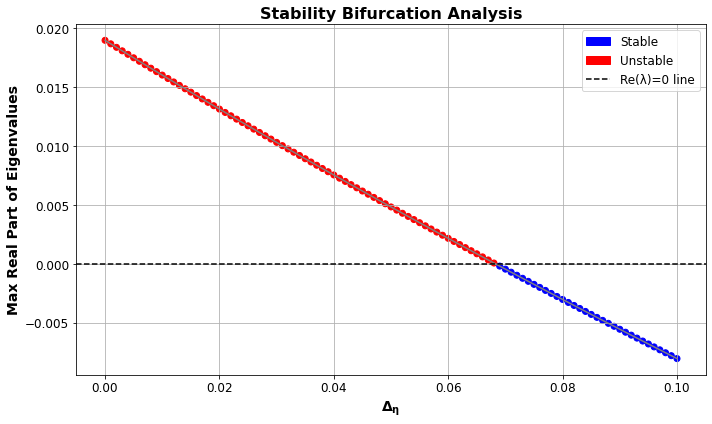

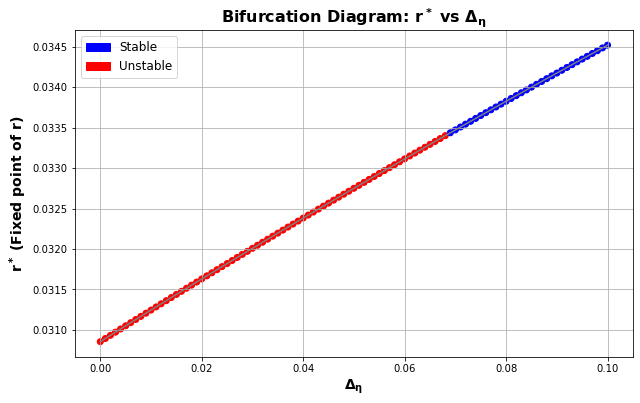

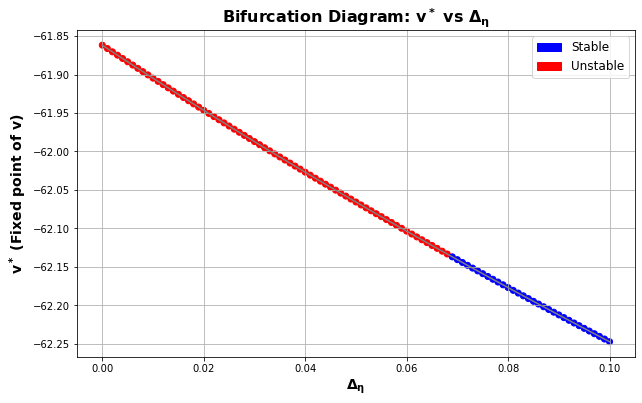

In [156]:
Delta_values = np.linspace(0,0.1,101)
etaBar = 0.8  # Held constant for this sweep

# Storage
delta_success = []
max_real_eigvals = []
r_fixed = []
v_fixed = []
stabilities = []
eigenvalue_records = []

initial_guess = [0.12, -62]

# --- Loop over Delta_eta values ---
for Delta_eta in Delta_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar, Delta_eta,), full_output=True)

    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Construct Jacobian
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        # Calculate eigenvalues
        eigvals = np.linalg.eigvals(J)
        eigenvalue_records.append((Delta_eta, eigvals.copy()))  # Save for inspection

        # Track stability and fixed points
        max_real_part = np.max(eigvals.real)
        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        v_fixed.append(v_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')
        delta_success.append(Delta_eta)

        print(f"Δη = {Delta_eta:.6f}, Max Re(λ): {max_real_part:.6f}, Stability: {stabilities[-1]}")
        initial_guess = [r_fp, v_fp]

# Convert to arrays
delta_success = np.array(delta_success)
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
v_fixed = np.array(v_fixed)
stabilities = np.array(stabilities)

# --- Print eigenvalues near bifurcation point ---
print("\n--- Eigenvalues near bifurcation (Δη ≈  0.039117) ---")
for Delta_eta, eigs in eigenvalue_records:
    if  0.067 <= Delta_eta <= 0.069:
        print(f"\nΔη = {Delta_eta:.6f}")
        for idx, eig in enumerate(eigs):
            re = eig.real
            im = eig.imag
            sign = '+' if im >= 0 else '-'
            print(f"  λ_{idx+1} = {re:.4f} {sign} {abs(im):.4f}i")

# --- Plotting ---
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# Plot: Max real eigenvalue vs Delta_eta
plt.figure(figsize=(10, 6))
plt.plot(delta_success, max_real_eigvals, color='gray')
plt.scatter(delta_success, max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Max Real Part of Eigenvalues', fontsize=14, fontweight='bold')
plt.title('Stability Bifurcation Analysis', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[
    stable_patch,
    unstable_patch,
    plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")
], fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('BifurcationDiagramDelta.png')
plt.show()

# Plot: r* vs Delta_eta
plt.figure(figsize=(10, 6))
plt.scatter(delta_success, r_fixed, c=colors)
plt.plot(delta_success, r_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{r^*}$ (Fixed point of $\mathbf{r}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: $\mathbf{r^*}$ vs $\mathbf{\Delta_{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.savefig('BifurcationDiagramRDelta.png')
plt.show()

# Plot: v* vs Delta_eta
plt.figure(figsize=(10, 6))
plt.scatter(delta_success, v_fixed, c=colors)
plt.plot(delta_success, v_fixed, color='gray', linestyle='-')
plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{v^*}$ (Fixed point of $\mathbf{v}$)', fontsize=14, fontweight='bold')
plt.title(r'Bifurcation Diagram: $\mathbf{v^*}$ vs $\mathbf{\Delta_{\eta}}$', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch], fontsize=12)
plt.savefig('BifurcationDiagramVDelta.png')
plt.show()


In [157]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import numpy as np

# Ensure you already have these from your simulation
# delta_success = array of Delta_eta where fixed points exist
# max_real_eigvals = array of corresponding max real eigenvalues

# Interpolate the eigenvalue function
eig_interp = interp1d(delta_success, max_real_eigvals, kind='cubic')

# Search for zero-crossing of interpolated curve
# We loop through each pair of consecutive Delta values to find sign changes
bifurcation_points = []
for i in range(len(delta_success) - 1):
    if max_real_eigvals[i] * max_real_eigvals[i+1] < 0:
        try:
            bif_point = brentq(eig_interp, delta_success[i], delta_success[i+1])
            bifurcation_points.append(bif_point)
        except ValueError:
            continue  # Skip intervals where brentq fails

# Print results
if bifurcation_points:
    for idx, point in enumerate(bifurcation_points):
        print(f"Bifurcation point {idx+1}: Δη ≈ {point:.6f}")
else:
    print("No bifurcation point found in the scanned range.")


Bifurcation point 1: Δη ≈ 0.068246


In [158]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.8
Delta =  0.068246
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {Delta:}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.068246, Fixed point (r, v, u, s, p): 0.03340981521414101, -62.134126001820945, -16.154872760473445, 0.2763914820009414, 0.2763914820009414
Residuals (should be close to zero):
dr/dt, dv/dt: [5.28280663571884e-12, -1.6396617397163027e-10]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [159]:
r_fp =   0.03340981521414101
v_fp =-62.134126001820945
u_fp = -16.154872760473445
s_fp = 0.2763914820009414
p_fp = 0.2763914820009414
etaBar = 0.8
Delta = 0.068246
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-2.60083765e-02  2.67278522e-03  0.00000000e+00 -6.68196304e-03
   0.00000000e+00]
 [-1.64870830e+01 -2.60083765e-02 -1.00000000e+00 -1.57317480e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-1.6422603079499594e-09+0.27983225022355734j)
Corresponding eigenvector:
[ 0.00131927-0.01052389j  0.99262036+0.j          0.02922576-0.08178311j
 -0.0488141 -0.01428695j -0.03664816-0.05585419j]

Eigenvalue 2: (-1.6422603079499594e-09-0.27983225022355734j)
Corresponding eigenvector:
[ 0.00131927+0.01052389j  0.99262036-0.j          0.02922576+0.08178311j
 -0.0488141 +0.01428695j -0.03664816+0.05585419j]

Eigenvalue 3: (-0.3501554838551686+0.081467488033077j)
Corresponding eigenvector:
[-0.0019784 -0.0009318

In [160]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.5
Delta = 0.02
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {Delta:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.02, Fixed point (r, v, u, s, p): 0.022621516128065153, -62.17285501747697, -16.164942304544013, 0.18714244085665405, 0.18714244085665405
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.0060311958492996e-15, 2.6478819137309983e-14]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


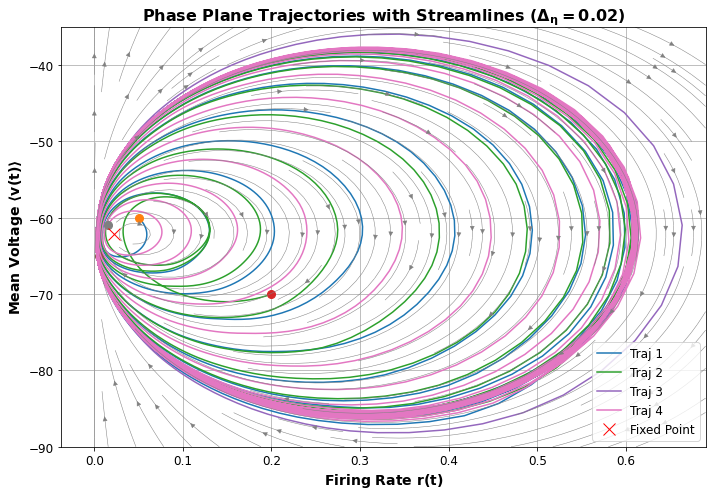

In [161]:
r_fp, v_fp, u_fp, s_fp, p_fp = 0.022621516128065153, -62.17285501747697, -16.164942304544013, 0.18714244085665405, 0.18714244085665405
etaBar = 0.8
Delta = 0.02
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.69, 25)
v = np.linspace(-90, -35, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\Delta_{\eta} = 0.02)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_DeltaEta_0.02.png')
plt.show()

In [162]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar, Delta):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0.0120 , -62.2695]  # initial guesses for r, v
etaBar = 0.8
Delta = 0.1
fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,Delta, ))
r_fp, v_fp = fixed_point
u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

# Check additional conditions explicitly
dudt = a * (b * v_fp - u_fp) + d * r_fp
dsdt = -s_fp / tauS + p_jump * r_fp
dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

# Print all equilibrium variables
print(f"Delta = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

# Verify residuals for ALL equations
print("Residuals (should be close to zero):")
print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar, Delta))
print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

# Update guess for next iteration
initial_guess = [r_fp, v_fp]

Delta = 0.80, Fixed point (r, v, u, s, p): 0.03451941904603843, -62.24713173011216, -16.184254249829163, 0.28557097148827754, 0.28557097148827754
Residuals (should be close to zero):
dr/dt, dv/dt: [3.392490281750593e-14, -1.535549465359054e-12]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


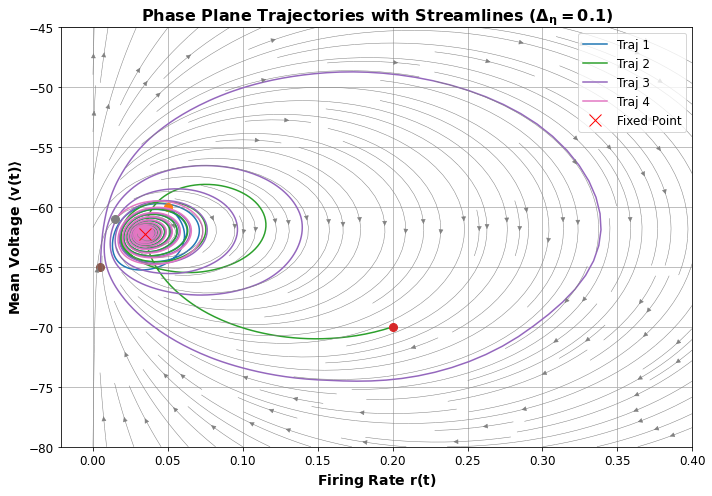

In [163]:
r_fp, v_fp, u_fp, s_fp, p_fp =   0.03451941904603843, -62.24713173011216, -16.184254249829163, 0.28557097148827754, 0.28557097148827754
etaBar = 0.8
Delta = 0.1
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.4, 25)
v = np.linspace(-80, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines

plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.grid(True)
plt.title(r"Phase Plane Trajectories with Streamlines $\mathbf{(\Delta_{\eta} = 0.1)}$", fontsize=16, fontweight='bold')
plt.ylabel(r"Mean Voltage $\mathbf{\langle v(t) \rangle }$", fontsize=14, fontweight='bold')
plt.xlabel(r"Firing Rate $\mathbf{r(t)}$", fontsize=14, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('TrajectoryPlot_DeltaEta_0.1.png')
plt.show()

# Oscillation Frequency

In [164]:
# Define the mean-field ODE system
def mean_field_odes(t, y, Delta, etaBar):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]

In [188]:
def compute_oscillation_frequency(t, r, t_transient=300.0):
    """
    Computes the dominant oscillation frequency of the signal r(t) after discarding an initial transient period.
    
    Parameters:
        t : array-like
            Time array in milliseconds.
        r : array-like
            Signal array (e.g., firing rate) corresponding to times in t.
        t_transient : float, optional
            Time (in ms) before which data are discarded to remove the initial transient, default is 300 ms.
    
    Returns:
        freq_hz : float or None
            The estimated frequency in Hz computed from the average inter-peak interval.
            If fewer than two peaks are detected, returns None.
    """
    from scipy.signal import find_peaks
    import numpy as np

    # Discard data before t_transient
    mask = t >= t_transient
    if np.sum(mask) < 2:
        return None
    
    t_trim = t[mask]
    r_trim = r[mask]
    
    # Find the indices of the peaks in the trimmed signal
    peaks, _ = find_peaks(r_trim, height=0)
    if len(peaks) < 2:
        return None  # Not enough peaks to compute period
    
    # Compute the inter-peak intervals (in milliseconds)
    peak_times = t_trim[peaks]
#     print(peak_times)
    intervals = np.diff(peak_times)
    avg_period_ms = np.mean(intervals)
    
    # Convert average period to frequency in Hz (1 s = 1000 ms)
    freq_hz = 1000.0 / avg_period_ms
    return freq_hz


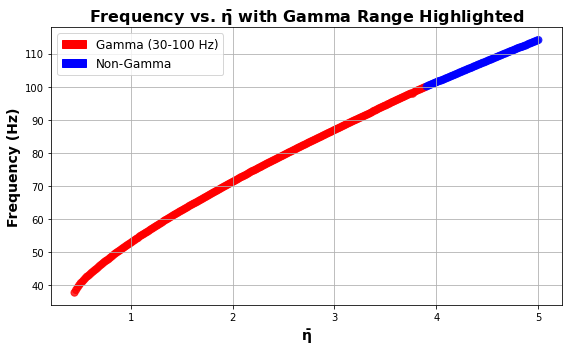

In [199]:
etaBar_test_values = np.linspace(0.45,5,300)  # e.g., 0 to 1 in steps of 0.05
frequencies = []
gamma_range = []
g = 0.2
Delta = 0.02
# Pick one specific initial condition
init_cond = [0.05, -60, -15, 0.1, 0.1]

for etaBar in etaBar_test_values:
    # Solve the system with one set of initial conditions
    sol = solve_ivp(
        mean_field_odes,
        t_span,
        init_cond,    # <-- must be 1D
        t_eval=t_eval,
        args=(Delta, etaBar)
    )

    # 2) Extract r(t)
    r_of_t = sol.y[0]

    # 3) Compute frequency
    freq = compute_oscillation_frequency(sol.t, r_of_t, t_transient=300.0)
    frequencies.append(freq)

    # 4) Check if in gamma band
    in_gamma = (freq is not None) and (30 <= freq <= 100)
    gamma_range.append(in_gamma)

# Summarize results
# for val, freq, gamma_flag in zip(etaBar_test_values, frequencies, gamma_range):
#     if freq is not None:
#         print(f"etaBar={val:.2f}, freq={freq:.2f} Hz, in gamma? {gamma_flag}")
#     else:
#         print(f"etaBar={val:.2f}, freq=None, no clear peaks")
# Suppose after running your loop you have:
#  etaBar_test_values, frequencies, gamma_range
#  where gamma_range is a list of booleans (True/False).
#  frequencies is either a float (Hz) or None if no peaks found.

# For plotting convenience, let's replace None with np.nan in frequencies
freqs_cleaned = [f if f is not None else np.nan for f in frequencies]

# Create a color list: 'red' if gamma_range[i] is True, else 'blue'
colors = ['red' if g else 'blue' for g in gamma_range]

plt.figure(figsize=(8,5))

# Scatter plot: x = etaBar, y = frequency, color depends on gamma_range
plt.scatter(etaBar_test_values, freqs_cleaned, c=colors, alpha=0.8, s=50)

plt.xlabel(r'$\mathbf{\bar{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Frequency (Hz)', fontsize=14, fontweight='bold')
plt.title(r'Frequency vs. $\mathbf{\bar{\eta}}$ with Gamma Range Highlighted', fontsize=16, fontweight='bold')
plt.grid(True)

# Custom legend handles
import matplotlib.patches as mpatches
gamma_patch = mpatches.Patch(color='red', label='Gamma (30-100 Hz)')
non_gamma_patch = mpatches.Patch(color='blue', label='Non-Gamma')
plt.legend(handles=[gamma_patch, non_gamma_patch], fontsize=12)
plt.savefig('Freq_EtaBar.png')
plt.tight_layout()
plt.show()


In [200]:
import numpy as np

# Convert gamma_range and etaBar_test_values to numpy arrays
eta_arr = np.array(etaBar_test_values)
gamma_arr = np.array(gamma_range)

# Find the first index where the gamma flag changes from True to False.
transition_idx = np.where((gamma_arr[:-1] == True) & (gamma_arr[1:] == False))[0]

if transition_idx.size > 0:
    # Take the first transition for instance.
    idx = transition_idx[0]
    # Optionally perform linear interpolation between etaBar values at the transition.
    eta1 = eta_arr[idx]
    eta2 = eta_arr[idx + 1]
    transition_eta = (eta1 + eta2) / 2.0
    print("Transition from Gamma to Non-Gamma occurs at etaBar approximately:", transition_eta)
else:
    print("No transition from Gamma to Non-Gamma was detected.")


Transition from Gamma to Non-Gamma occurs at etaBar approximately: 3.8967391304347827


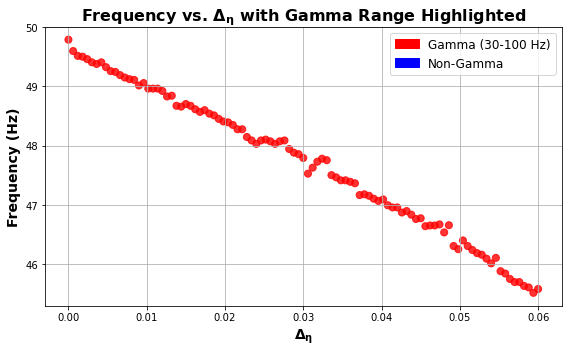

In [198]:
# Define a range of Delta values:
delta_test_values = np.linspace(0.0, 0.06, 101)  # example: 51 steps from 0 to 0.1
etaBar=0.8
g= 0.2
# Arrays to store results
frequencies = []
gamma_range = []

# Pick one specific initial condition (example)
init_cond = [0.05, -60, -15, 0.1, 0.1]

# Sweep over Delta
for delta_val in delta_test_values:
    # Solve the system with one set of initial conditions
    sol = solve_ivp(
        mean_field_odes,
        t_span,
        init_cond,
        t_eval=t_eval,
        args=(delta_val, etaBar)  # pass in your fixed etaBar, but vary Delta
    )

    # Extract r(t)
    r_of_t = sol.y[0]

    # Compute frequency (peak-finding method)
    freq = compute_oscillation_frequency(sol.t, r_of_t, t_transient=300.0)
    frequencies.append(freq)

    # Check if in gamma band
    in_gamma = (freq is not None) and (30 <= freq <= 100)
    gamma_range.append(in_gamma)

# # Summarize results in the console
# for val, freq, gamma_flag in zip(delta_test_values, frequencies, gamma_range):
#     if freq is not None:
#         print(f"Delta={val:.4f}, freq={freq:.2f} Hz, in gamma? {gamma_flag}")
#     else:
#         print(f"Delta={val:.4f}, freq=None, no clear peaks")

# Prepare for plotting: replace None with np.nan
freqs_cleaned = [f if f is not None else np.nan for f in frequencies]

# Create color list: 'red' if gamma_range[i] is True, else 'blue'
colors = ['red' if g else 'blue' for g in gamma_range]

# Plot
plt.figure(figsize=(8,5))
plt.scatter(delta_test_values, freqs_cleaned, c=colors, alpha=0.8, s=50)

plt.xlabel(r'$\mathbf{\Delta_{\eta}}$', fontsize=14, fontweight='bold')
plt.ylabel('Frequency (Hz)', fontsize=14, fontweight='bold')
plt.title(r'Frequency vs. $\mathbf{\Delta_{\eta}}$ with Gamma Range Highlighted', fontsize=16, fontweight='bold')
plt.grid(True)

# Legend for gamma vs. non-gamma
gamma_patch = mpatches.Patch(color='red', label='Gamma (30-100 Hz)')
non_gamma_patch = mpatches.Patch(color='blue', label='Non-Gamma')
plt.legend(handles=[gamma_patch, non_gamma_patch], fontsize=12)
plt.savefig('Freq_Delta.png')
plt.tight_layout()
plt.show()
